In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

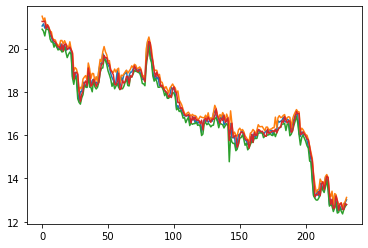

In [2]:
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data\\_Rolling"
TICKER = "MA_ARD"

training = pd.read_csv(f"{TICKER_DIR}\\{TICKER}.csv", header=0)
training = training.iloc[:, :4].values
plt.plot(training, label="Ticker Values")

In [3]:
def sliding_windows(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(x))
dataY = Variable(torch.Tensor(y))

trainX = Variable(torch.Tensor(x[:train_size]))
trainY = Variable(torch.Tensor(y[:train_size]))

testX = Variable(torch.Tensor(x[train_size:]))
testY = Variable(torch.Tensor(y[train_size:]))

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

torch.Size([181, 4, 4])
torch.Size([181, 4])
torch.Size([46, 4, 4])
torch.Size([46, 4])


In [50]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [64]:
num_epochs = 2000
learning_rate = 0.01

input_size = 4
hidden_size = 4
num_layers = 1

num_classes = 4

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print(f"Epoch: {epoch}, loss: {loss.item()}")

Epoch: 0, loss: 0.44571518898010254
Epoch: 100, loss: 0.006028631702065468
Epoch: 200, loss: 0.0049009486101567745
Epoch: 300, loss: 0.0042244200594723225
Epoch: 400, loss: 0.003803812200203538
Epoch: 500, loss: 0.0036149127408862114
Epoch: 600, loss: 0.0035301619209349155
Epoch: 700, loss: 0.003486332716420293
Epoch: 800, loss: 0.003459002124145627
Epoch: 900, loss: 0.0034392187371850014
Epoch: 1000, loss: 0.0034235615748912096
Epoch: 1100, loss: 0.003410459030419588
Epoch: 1200, loss: 0.0033990314695984125
Epoch: 1300, loss: 0.0033887086901813745
Epoch: 1400, loss: 0.003379102097824216
Epoch: 1500, loss: 0.0033699367195367813
Epoch: 1600, loss: 0.0033610190730541945
Epoch: 1700, loss: 0.003352210158482194
Epoch: 1800, loss: 0.0033434126526117325
Epoch: 1900, loss: 0.003334550652652979


torch.Size([182, 4, 4])
torch.Size([182, 4])


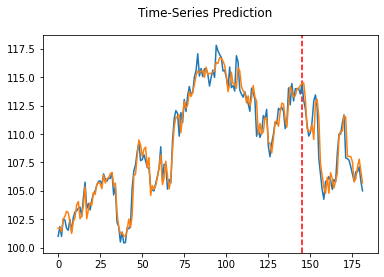

In [74]:
lstm.eval()
train_predict = lstm(dataX)
print(dataX.shape)
print(train_predict.shape)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

open_ = data_predict[:, -1]
y_  = dataY_plot[:, -1]

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(y_)
plt.plot(open_)
plt.suptitle('Time-Series Prediction')
plt.show()

(116, 14, 4)
(116, 4)
(30, 14, 4)
(30, 4)


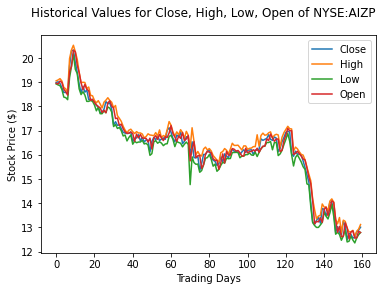

In [182]:
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data\\_Rolling"

training = pd.read_csv(f"{TICKER_DIR}\\MA_ARD.csv", header=0)
training = training.tail(160).iloc[:, :4].values
# training = training.iloc[:, 0:4:3].values

plt.plot(training)
plt.suptitle("Historical Values for Close, High, Low, Open of NYSE:AIZP")
plt.ylabel("Stock Price ($)")
plt.xlabel("Trading Days")
plt.legend(("Close", "High", "Low", "Open"))
#plt.savefig("C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\AIZP_hist.jpg")

def sliding_windows(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training)

seq_length = 14
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(x))
dataY = Variable(torch.Tensor(y))

# trainX = Variable(torch.Tensor(x[:train_size]))
# trainY = Variable(torch.Tensor(y[:train_size]))

# testX = Variable(torch.Tensor(x[train_size-1:]))
# testY = Variable(torch.Tensor(y[train_size-1:]))

trainX = x[:train_size]
trainY = y[:train_size]

testX = x[train_size-1:]
testY = y[train_size-1:]

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

In [183]:
keras.backend.clear_session()
model = Sequential()
# model.add(LSTM(4, stateful=True, return_sequences=True, batch_input_shape=(4, 4, 4)))
# model.add(LSTM(4, stateful=True, batch_input_shape=(4, 4, 4)))
# model.add(Dense(4, activation="sigmoid"))
model.add(LSTM(14))
model.add(Dense(1, activation="relu"))
opt = Adam(learning_rate=0.01)
#model.compile(loss="mean_squared_error", optimizer=opt)
model.compile(loss="binary_crossentropy", optimizer=opt)

In [184]:
for i in range(100):
    model.fit(trainX, trainY, epochs=5, batch_size=4, verbose=1, shuffle=False)
    model.reset_states()

ValueError: Error when checking target: expected dense_1 to have shape (1,) but got array with shape (4,)

In [177]:
scores = model.evaluate(testX, testY, batch_size=4)
print(scores * 100)
#model.reset_states()
#test_predict = model.predict(testX, batch_size=4)

# train_predict = sc.inverse_transform(train_predict)
# trainY = sc.inverse_transform(trainY)
# test_predict = sc.inverse_transform(test_predict)
# testY = sc.inverse_transform(testY)

32/32 [==============================] - 0s 281us/step
67.95165464282036


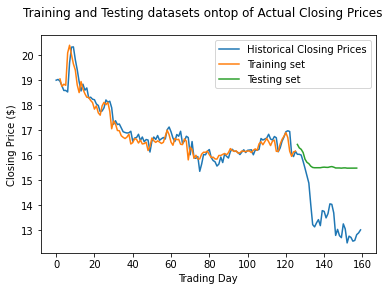

In [151]:
offset = len(test_predict)
trainPredictPlot = np.empty_like(training_data[:, 0])
trainPredictPlot[:] = np.nan
trainPredictPlot[2:len(train_predict)+2] = train_predict[:, 0]
# shift test predictions for plotting
testPredictPlot = np.empty_like(training_data[:, 0])
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict)+2:len(train_predict)+offset+2] = test_predict[:, 0]

# plot baseline and predictions
fig = plt.figure()
plt.plot(sc.inverse_transform(training_data)[:, 0], label="Historical Closing Prices")
plt.plot(trainPredictPlot[:], label="Training set")
plt.plot(testPredictPlot[:], label="Testing set")
fig.suptitle("Training and Testing datasets ontop of Actual Closing Prices")
plt.ylabel("Closing Price ($)")
plt.xlabel("Trading Day")
plt.legend()
plt.show()
#fig.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\{TICKER}.jpg")